# Experimento mestrado 2 - Ex 1
## Executando na pasta principal

In [1]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir('../../../../') #Executando na pasta Visual_Memory
import sys

In [2]:
sys.path.append('./Visual_Memory/include')
sys.path.append('./Visual_Memory/src')
sys.path.append('./Blackboard/src/')
from Blackboard import *
os.chdir('./Visual_Memory')
bkb = Blackboard()
os.chdir('../')

### Criando lista de videos 

In [3]:
address = "/home/fei/Videos/Ex2/Back"
Files = os.listdir(address)
Files.sort()

In [4]:
filesrob = []
filescel = []
for video in Files:
    if video.find('cel') == -1:
        filesrob.append(video)
    else:
        filescel.append(video)

Files = zip(filesrob, filescel)

### Preparando sistema:

In [5]:
# Files = Files[2:3]
# print Files

In [6]:
os.system("mkdir Ex2-Back")
listTime = []
for vision, debug in Files:
    # Criando sh da visão
    text = open("./runvision.sh", "w")
    text.write("#!/bin/bash\nPYTHONPATH=~/models/research/slim:~/models/research/object_detection:~/models/research:$PYTHONPATH\n\ncd Vision/\npython vision.py --dnn --v " + address + "/" + vision)
    text.close()
    os.system("chmod 755 runvision.sh")
    
    # Criando sh da Visual Memory
    text = open("./runvisualmemory.sh", "w")
    text.write("#!/bin/bash\n\ncd Visual_Memory/\npython visualMemory.py --d --sd --nr 4 --p 333")
    text.close()
    os.system("chmod 755 runvisualmemory.sh")

    # Limpando bkb
    os.system("screen -d -m -S 'Vision' './runvision.sh'")
    time.sleep(3)
    os.system("kill $(pidof -x ./runvision.sh)")
    
    #Executando Visual Memory
    os.system("screen -d -m -S 'VisualMemory' './runvisualmemory.sh'")
    os.system("gnome-terminal -x sh -c 'screen -R VisualMemory'")
    
    #Executando visão[tempo, x, y, vx, vy, ex, ey, evx, evy, cx, cy, cvx, cvy, time]
    os.system("screen -d -m -S 'Vision' './runvision.sh'")
#     os.system("gnome-terminal -x sh -c 'screen -R Vision'")
    
    #Vendo video
#     os.system("gnome-terminal -x sh -c 'sleep 4 && vlc " + address + "/" + debug + "'")
    
    listTime.append([vision.split("_")[0], time.time()])
    
    while os.system("pidof -x ./runvision.sh") == 0:
        time.sleep(1)
    
    os.system("kill $(pidof -x ./runvisualmemory.sh)")
    os.system("kill $(pidof -x ./runvision.sh)")
    os.system("kill $(pidof -x vlc)")
    
    os.system("mv ./Visual_Memory/Data/Thread-1-Robots.npy ./Ex2-Back/" + vision.split("_")[0] + "-2.npy")
    os.system("mv ./Visual_Memory/Data/Thread-2-Robots.npy ./Ex2-Back/" + vision.split("_")[0] + "-1.npy")
    
    #clear bkb
    for number in xrange(1, 22):
        bkb.write_int("VISION_RB" + str(number).zfill(2) + "_TAG", 0)
    
    time.sleep(5)
    
    os.system("screen -d -m -S 'VisualMemory' './runvisualmemory.sh'")
    os.system("gnome-terminal -x sh -c 'screen -R VisualMemory'")
    
    time.sleep(10)
    
    os.system("kill $(pidof -x ./runvisualmemory.sh)")
    
    time.sleep(5)

text = open("./time.txt", "w")
text.write(str(listTime))
text.close()
raw_input("Esperando..")

Esperando..


''

In [7]:
address = "./Ex2-Back"
Files = os.listdir(address)
Files.sort()
Files = [item for item in Files if item.find("-1") != -1]
listData = []
for name in Files:
    print address + "/" + name
    dataRob = np.load(address + "/" + name)
    dataExp = []
    for tempo, [x, y, vx, vy], [ex, ey, evx, evy], [cx, cy, cvx, cvy], t in dataRob:
        dataExp.append([tempo, x, y, vx, vy, ex, ey, evx, evy, cx, cy, cvx, cvy, t])
    dataExp = pd.DataFrame(
        dataExp,
        columns=[
            "Tempo",
            "Posição X",
            "Posição Y",
            "Velocidade X",
            "Velocidade Y",
            "Erro PX",
            "Erro PY",
            "Erro VX",
            "Erro VY",
            "Covariância PX",
            "Covariância PY",
            "Covariância VX",
            "Covariância VY",
            "Time",
        ]
    )
#     dataExp["Tempo"] = dataExp["Tempo"] - dataExp["Tempo"][0]
    listData.append(dataExp)

./Ex2-Back/01-1.npy
./Ex2-Back/02-1.npy
./Ex2-Back/03-1.npy
./Ex2-Back/04-1.npy
./Ex2-Back/05-1.npy
./Ex2-Back/06-1.npy
./Ex2-Back/07-1.npy
./Ex2-Back/08-1.npy
./Ex2-Back/09-1.npy
./Ex2-Back/10-1.npy


In [8]:
listTime = pd.DataFrame(
    np.loadtxt("time.txt")[:,1],
    index = [str(int(i)) for i in np.loadtxt("time.txt")[:,0]]
)
for data, time in zip(listData, listTime[0]):
    data["Tempo"] = data["Tempo"] - time

# for i in xrange(len(listData)):
#     listData[i]["Erro PY"] *= 50/listData[i]["Erro PY"][0]

In [9]:
listData[1]

,Tempo,Posição X,Posição Y,Velocidade X,Velocidade Y,Erro PX,Erro PY,Erro VX,Erro VY,Covariância PX,Covariância PY,Covariância VX,Covariância VY,Time
0,13.987778,250.752406,-136.842804,0.000000,0.000000,140.268951879121,140.268951879121,500,500,140.268952,0.0,217.731953,0.0,-2
1,14.273302,250.752406,-136.842804,0.000000,0.000000,305.366418906785,305.366418906785,500,500,305.366419,0.0,360.494018,0.0,-2
2,14.607091,250.752406,-136.842804,0.000000,0.000000,601.731707190153,601.731707190153,500,500,601.731707,0.0,527.388453,0.0,-2
3,15.050803,304.814128,-151.239786,34.033834,-9.063428,105.353925094468,105.353925094468,78.7810521905870,78.7810521905870,105.353925,0.0,80.150819,0.0,-2
4,15.272748,312.367769,-153.251369,34.033834,-9.063428,144.812803026787,144.812803026787,78.7810521905870,78.7810521905870,144.812803,0.0,97.635883,0.0,-2
5,15.605701,323.699435,-156.269064,34.033834,-9.063428,218.562603728942,218.562603728942,78.7810521905870,78.7810521905870,218.562604,0.0,123.866269,0.0,-2
6,16.083403,337.238324,-155.623595,32.820112,-6.842739,66.6089358995670,66.6089358995670,21.3457445687978,21.3457445687978,66.608936,0.0,32.825769,0.0,-2
7,16.272248,343.436236,-156.915811,32.820112,-6.842739,79.7681359515677,79.7681359515677,21.3457445687978,21.3457445687978,79.768136,0.0,36.856805,0.0,-2
8,16.605174,354.362905,-159.193937,32.820112,-6.842739,106.675272522416,106.675272522416,21.3457445687978,21.3457445687978,106.675273,0.0,43.963359,0.0,-2
9,17.045685,344.318838,-144.635350,24.237572,-0.687244,46.1694600933132,46.1694600933132,8.66108486890941,8.66108486890941,46.169460,0.0,17.153852,0.0,-2


In [10]:
interposy = listData[0]["Posição Y"].values
interposy

listData[0]["Erro PY"] = listData[0]["Erro PY"].values.astype(float)
intererry = listData[0]["Erro PY"].values
intererry

vel = ((600/max(listData[0]["Tempo"]))*listData[0]["Tempo"] - 300).values

for data in listData[1:]:
    newposy = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        data["Posição Y"]
    )
    
    data["Erro PY"] = data["Erro PY"].values.astype(float)
    newerry = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        data["Erro PY"]
    )
    
    b = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        ((600/max(data["Tempo"]))*data["Tempo"] - 300).values
    )
    
    try:
        interposy = np.append(interposy, [newposy], axis=0)
        intererry = np.append(intererry, [newerry], axis=0)
        vel = np.append(vel, [b], axis=0)
    except ValueError:
        interposy = np.append([interposy], [newposy], axis=0)
        intererry = np.append([intererry], [newerry], axis=0)
        vel = np.append([vel], [b], axis=0)

In [11]:
# zip(interposy.mean(axis=0), np.sqrt(interposy.var(axis=0)))
# zip(intererry.mean(axis=0), np.sqrt(intererry.var(axis=0)))
# zip(vel.mean(axis=0), np.sqrt(vel.var(axis=0)))

In [12]:
t = max(listData[0]["Tempo"])
# t = 0
print "Conta x:", (600/max(listData[0]["Tempo"]))*t - 300, "cm\nVelocidade:", (600/max(listData[0]["Tempo"])), "cm/s"

Conta x: 300.0 cm
Velocidade: 10.2999793582 cm/s


In [13]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [14]:
os.system("mkdir /home/vinicius/Dropbox/Projeto\ Mestrado/Dados/")
os.system("sleep 3")

0

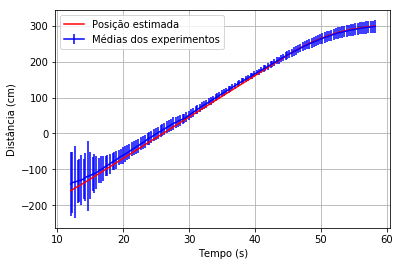

In [15]:
limit = 100

# plt.figure(figsize = (12,8))
plt.plot(
    listData[0]["Tempo"], # Tempo
    vel.mean(axis = 0), # Desejado
    "r", # Cor e padrão
    label = u"Posição estimada",
)

plt.errorbar(
    listData[0]["Tempo"], # Tempo
    interposy.mean(axis = 0), # Posição
    yerr = np.clip(intererry.mean(axis = 0), -limit, limit), # Erro Y
    color = "b", # Cor e padrão
    label = u"Médias dos experimentos",
)

plt.legend(loc = 2)
plt.xlabel(u"Tempo (s)")
plt.ylabel(u"Distância (cm)")
# plt.title(u"Distância do rôbo em Y pelo tempo")

plt.grid()
# plt.savefig("/home/vinicius/Dropbox/Projeto Mestrado/Imagens/ex2graf1-1.png", dpi = 720)
plt.savefig("/home/fei/Imagens/ex2graf1-1.png", dpi = 720)

In [16]:
for data, time in zip(listData, listTime[0]):
    data["Posição Y"] = abs((600/max(data["Tempo"]))*data["Tempo"] - 300 - data["Posição Y"])

In [17]:
interposy = listData[0]["Posição Y"].values
interposy

listData[0]["Erro PY"] = listData[0]["Erro PY"].values.astype(float)
intererry = listData[0]["Erro PY"].values
intererry

vel = ((600/max(listData[0]["Tempo"]))*listData[0]["Tempo"] - 300).values

for data in listData[1:]:
    newposy = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        data["Posição Y"]
    )
    
    data["Erro PY"] = data["Erro PY"].values.astype(float)
    newerry = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        data["Erro PY"]
    )
    
    b = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        ((600/max(data["Tempo"]))*data["Tempo"] - 300).values
    )
    
    try:
        interposy = np.append(interposy, [newposy], axis=0)
        intererry = np.append(intererry, [newerry], axis=0)
        vel = np.append(vel, [b], axis=0)
    except ValueError:
        interposy = np.append([interposy], [newposy], axis=0)
        intererry = np.append([intererry], [newerry], axis=0)
        vel = np.append([vel], [b], axis=0)

IOError: [Errno 2] No such file or directory: '/home/vinicius/Dropbox/Projeto Mestrado/Imagens/ex2graf2-1.png'

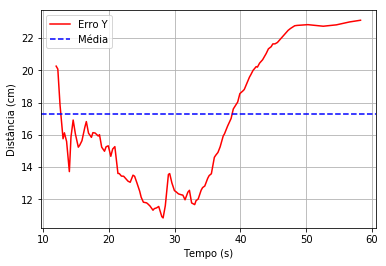

In [18]:
# plt.figure(figsize=(12,8))
plt.plot(
    listData[0]["Tempo"], # Tempo
    interposy.mean(axis = 0), # Desejado
    "r", # Cor e padrão
    label = u"Erro Y",
)

plt.axhline(
    interposy.mean( ),
    color = 'b',
    linestyle = '--',
    label = u"Média",
)

plt.legend(loc = 2)
plt.xlabel(u"Tempo (s)")
plt.ylabel(u"Distância (cm)")
# plt.title(u"Erro de distância em Y pelo tempo")

plt.grid()
plt.savefig("/home/vinicius/Dropbox/Projeto Mestrado/Imagens/ex2graf2-1.png", dpi = 720)

In [19]:
interposy = interposy.mean(axis=0)

In [20]:
print interposy.mean(), "±", np.sqrt(interposy.var( )), "cm"

17.32205387630861 ± 4.2185876513478595 cm


In [ ]:
with open("/home/vinicius/Dropbox/Projeto Mestrado/Dados/media.txt", "w") as f:
    f.write(str(round(interposy.mean( ), 2)))

with open("/home/vinicius/Dropbox/Projeto Mestrado/Dados/desvio.txt", "w") as f:
    f.write(str(round(np.sqrt(interposy.var( )), 2)))